In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
import warnings

In [2]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.wrappers.scikit_learn import KerasRegressor
import pickle
import glob
from tensorflow.keras.models import load_model

In [3]:
warnings.filterwarnings('ignore')

In [4]:
def augmentation_ts(time_series):

    augmented_series = pd.Series()

    # Calculate the number of elements in the original time series
    num_elements = len(time_series)

    # Iterate through the original time series
    for i in range(num_elements):
        
        # Append the current value from the original series
        augmented_series = augmented_series.append(pd.Series(time_series.iloc[i]))
        
        # Calculate the intermediate value by averaging the current and next day's values
        if i < num_elements - 1:
            intermediate_value = (time_series.iloc[i] + time_series.iloc[i + 1]) / 2
            augmented_series = augmented_series.append(pd.Series(intermediate_value))
            
    return augmented_series

In [5]:
def reshaper(twod_array):
    return twod_array.reshape((twod_array.shape[0], 1, twod_array.shape[1]))

In [6]:
def plot_descomposition(df, target):
    
    # Time series decomposition
    decomposition = seasonal_decompose(df[target], model='additive', period=30)
    
    # Plot
    fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=('Original', 'Trend', 'Seasonality', 'Residuos'))
    fig.add_trace(go.Scatter(x=df.index, y=df[target], mode='lines', name='Original'), row=1, col=1)
    fig.add_trace(go.Scatter(x=decomposition.trend.index, y=decomposition.trend, mode='lines', name='Trend'), row=2, col=1)
    fig.add_trace(go.Scatter(x=decomposition.seasonal.index, y=decomposition.seasonal, mode='lines', name='Seasonality'), row=3, col=1)
    fig.add_trace(go.Scatter(x=decomposition.resid.index, y=decomposition.resid, mode='lines', name='Residuos'), row=4, col=1)
    fig.update_layout(title_text='Descomposición de la serie de tiempo', showlegend=True)
    
    return fig

In [7]:
def create_features(df, date_col):
    
    # Convert the 'date' column to datetime
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Extract date-based features
    df['hour'] = df[date_col].dt.hour
    df['dayofweek'] = df[date_col].dt.dayofweek
    df['month'] = df[date_col].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df[date_col].dt.day
    df['weekofyear'] = df[date_col].dt.isocalendar().week
    df['weekofyear'] = df['weekofyear'].astype(int)
    
    # Set the 'date' column as the index
    df = df.set_index('date')
    
    return df

In [8]:
def add_lags(df, target, hours):
    """
    Add lagged values as new columns to a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - target (str): The column name for the target variable.
    - hours (int): The number of lagged hours to add.

    Returns:
    - pd.DataFrame: The DataFrame with added lagged columns.
    """
    
    # Create a dictionary mapping timestamps to target values
    target_map = df[target].to_dict()
    
    # Iterate through lag hours and add lagged columns
    for i in range(1, hours + 1):
        df[f'lag{i}'] = df.index.to_series() - pd.DateOffset(hours=i*8)
        df[f'lag{i}'] = df[f'lag{i}'].map(target_map)
    
    return df

In [9]:
# Read data
lavb_8h = pd.read_parquet("lavb_8h.parquet")
lavb_8h.sort_values(by='date', ascending=True, inplace=True)
lavb_8h.head(5)

,origin,destination,date,available
0,Los Angeles (CA),Stockton (CA),2023-05-15 00:00:00,160.0
1,Los Angeles (CA),Stockton (CA),2023-05-15 08:00:00,147.0
2,Los Angeles (CA),Stockton (CA),2023-05-15 16:00:00,17.0
3,Los Angeles (CA),Stockton (CA),2023-05-16 00:00:00,22.0
4,Los Angeles (CA),Stockton (CA),2023-05-16 08:00:00,47.0


In [13]:
aug_ts = augmentation_ts(lavb_8h['available'])
lavb_8h_aug = pd.DataFrame({'available': aug_ts})
lavb_8h_aug.reset_index(inplace=True, drop=True)
lavb_8h_aug

,available
0,160.0
1,153.5
2,147.0
3,82.0
4,17.0
...,...
852,91.0
853,97.0
854,103.0
855,90.5


In [14]:
lavb_8h_aug['date'] = pd.date_range(start=lavb_8h['date'].max() - pd.Timedelta(hours=8*(len(lavb_8h_aug)-1)), end=lavb_8h['date'].max(), freq='8H')
lavb_8h_aug

,available,date
0,160.0,2022-12-23 08:00:00
1,153.5,2022-12-23 16:00:00
2,147.0,2022-12-24 00:00:00
3,82.0,2022-12-24 08:00:00
4,17.0,2022-12-24 16:00:00
...,...,...
852,91.0,2023-10-03 08:00:00
853,97.0,2023-10-03 16:00:00
854,103.0,2023-10-04 00:00:00
855,90.5,2023-10-04 08:00:00


In [41]:
lavb_8h_aug.shape

(857, 2)

In [42]:
lavb_8h_aug.isna().sum()

available    0
date         0
dtype: int64

In [43]:
lavb_8h_aug.dtypes

available           float64
date         datetime64[ns]
dtype: object

In [44]:
px.line(lavb_8h_aug, x="date", y="available", markers = True)

In [45]:
plot_descomposition(lavb_8h_aug, "available")

In [15]:
df_features = create_features(lavb_8h_aug.copy(), "date")
df_features

,available,hour,dayofweek,month,dayofyear,dayofmonth,weekofyear
date,,,,,,,
2022-12-23 08:00:00,160.0,8,4,12,357,23,51
2022-12-23 16:00:00,153.5,16,4,12,357,23,51
2022-12-24 00:00:00,147.0,0,5,12,358,24,51
2022-12-24 08:00:00,82.0,8,5,12,358,24,51
2022-12-24 16:00:00,17.0,16,5,12,358,24,51
...,...,...,...,...,...,...,...
2023-10-03 08:00:00,91.0,8,1,10,276,3,40
2023-10-03 16:00:00,97.0,16,1,10,276,3,40
2023-10-04 00:00:00,103.0,0,2,10,277,4,40


In [47]:
px.box(df_features, x="hour", y="available")

In [48]:
px.box(df_features, x="dayofweek", y="available")

In [49]:
px.box(df_features, x="month", y="available")

In [50]:
px.box(df_features, x="dayofmonth", y="available")

In [51]:
px.box(df_features, x="weekofyear", y="available")

In [52]:
px.box(df_features, x="hour", y="available", color="dayofweek", animation_frame='month')

In [53]:
px.histogram(df_features, x="available", animation_frame='month')

In [54]:
px.histogram(df_features, x="available", animation_frame='dayofweek')

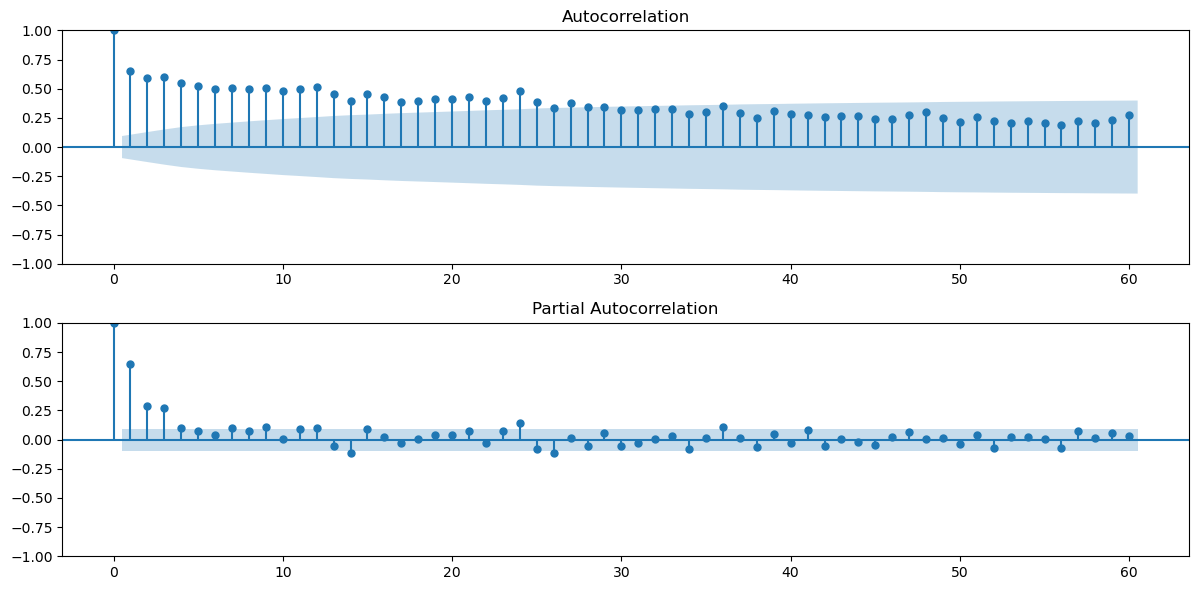

In [55]:
# Gráficos de autocorrelación y autocorrelación parcial
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plot_acf(lavb_8h['available'], ax=plt.gca(), lags=60)

plt.subplot(2, 1, 2)
plot_pacf(lavb_8h['available'], ax=plt.gca(), lags=60)

plt.tight_layout()
plt.show()

In [17]:
df_features = df_features.drop(['hour', 'dayofweek', 'month', 'dayofyear', 'dayofmonth', 'weekofyear'], axis=1)
df_features = add_lags(df_features, "available", 3)
df_features = df_features.dropna()
df_features

,available,lag1,lag2,lag3
date,,,,
2022-12-24 08:00:00,82.0,147.0,153.5,160.0
2022-12-24 16:00:00,17.0,82.0,147.0,153.5
2022-12-25 00:00:00,19.5,17.0,82.0,147.0
2022-12-25 08:00:00,22.0,19.5,17.0,82.0
2022-12-25 16:00:00,34.5,22.0,19.5,17.0
...,...,...,...,...
2023-10-03 08:00:00,91.0,93.5,96.0,111.5
2023-10-03 16:00:00,97.0,91.0,93.5,96.0
2023-10-04 00:00:00,103.0,97.0,91.0,93.5


In [18]:
X = df_features.drop(columns=['available'])
y = df_features['available']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [19]:
scaler = MinMaxScaler()
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test), scaler.fit_transform(pd.DataFrame(y_train)), scaler.transform(pd.DataFrame(y_test))

# KNN Model

In [20]:
# Apply KNN to forecast my time series (available) tunning hyperparamets without cross validation
grid_knn = None
if (len(glob.glob("knn_model_augd.pkl")) != 0):
    
     grid_knn = pickle.load(open('knn_model_augd.pkl','rb'))
     
else:
    
    pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('knn', KNeighborsRegressor())])

    param_grid = {'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'knn__weights': ['uniform', 'distance'],
                    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'knn__leaf_size': [10, 20, 30, 40, 50],
                    'knn__p': [1, 2]}

    grid_knn = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_knn.fit(X_train, y_train)
    # Export model to pickle
    pickle.dump(grid_knn, open('knn_model_augd.pkl', 'wb'))
    
print("Best parameters: ", grid_knn.best_params_)
print("Best score: ", grid_knn.best_score_)


Best parameters:  {'knn__algorithm': 'auto', 'knn__leaf_size': 20, 'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'distance'}
Best score:  -944.1997227110083


In [21]:
# Predictions
y_pred = grid_knn.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
models_metrics = [{'Model': 'KNN', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape}]
print(models_metrics)

# Plot predictions vs real values
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index, y=y_test, mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=X_test.index, y=y_pred, mode='lines', name='Predicción'))
fig.update_layout(title_text='Predicción vs Real (KNN)', showlegend=True)
fig.show()


[{'Model': 'KNN', 'MSE': 395.9155641406999, 'RMSE': 19.89762709824214, 'MAPE': 0.18498874389059053}]


# Ridge

In [22]:
# Apply Ridge to forecast my time series (available) tunning hyperparamets without cross validation
if (len(glob.glob("ridge_model_augd.pkl")) != 0):
    
    grid_rdg = pickle.load(open('ridge_model_augd.pkl','rb'))
        
else:
    
    pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('ridge', Ridge())])

    param_grid = {'ridge__alpha': [0.1, 0.5, 1, 5, 10, 50, 100],
                    'ridge__solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

    grid_rdg = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_rdg.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_rdg, open('ridge_model_augd.pkl', 'wb'))
    
print("Best parameters: ", grid_rdg.best_params_)
print("Best score: ", grid_rdg.best_score_)

Best parameters:  {'ridge__alpha': 0.1, 'ridge__solver': 'sag'}
Best score:  -575.6119018527595


In [23]:
# Calculate metrics
y_pred = grid_rdg.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
models_metrics.append({'Model': 'Ridge', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape})
print(models_metrics)

# Plot predictions vs real values
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index, y=y_test, mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=X_test.index, y=y_pred, mode='lines', name='Predicción'))
fig.update_layout(title_text='Predicción vs Real (Ridge)', showlegend=True)
fig.show()

[{'Model': 'KNN', 'MSE': 395.9155641406999, 'RMSE': 19.89762709824214, 'MAPE': 0.18498874389059053}, {'Model': 'Ridge', 'MSE': 339.3422882057687, 'RMSE': 18.42124556607855, 'MAPE': 0.1756253305970656}]


# Lasso

In [24]:
# Apply Lasso to forecast my time series (available) tunning hyperparamets without cross validation

if (len(glob.glob("lasso_model_augd.pkl")) != 0):
        
    grid_lss = pickle.load(open('lasso_model_augd.pkl','rb'))
        
else:
    
    pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('lasso', Lasso())])

    param_grid = {'lasso__alpha': [0.1, 0.5, 1, 5, 10, 50, 100],
                    'lasso__selection': ['cyclic', 'random']}
    
    grid_lss = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_lss.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_lss, open('lasso_model_augd.pkl', 'wb'))
        
print("Best parameters: ", grid_lss.best_params_)
print("Best score: ", grid_lss.best_score_)

Best parameters:  {'lasso__alpha': 0.1, 'lasso__selection': 'cyclic'}
Best score:  -566.3201942758141


In [25]:
# Calculate metrics
y_pred = grid_lss.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
models_metrics.append({'Model': 'Lasso', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape})
print(models_metrics)

# Plot predictions vs real values
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index, y=y_test, mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=X_test.index, y=y_pred, mode='lines', name='Predicción'))
fig.update_layout(title_text='Predicción vs Real (Lasso)', showlegend=True)
fig.show()

[{'Model': 'KNN', 'MSE': 395.9155641406999, 'RMSE': 19.89762709824214, 'MAPE': 0.18498874389059053}, {'Model': 'Ridge', 'MSE': 339.3422882057687, 'RMSE': 18.42124556607855, 'MAPE': 0.1756253305970656}, {'Model': 'Lasso', 'MSE': 349.5746294753926, 'RMSE': 18.696914972138924, 'MAPE': 0.17975920338533904}]


# Naive Bayes

In [ ]:
# Apply Naive Bayes to forecast my time series (available) tunning hyperparamets without cross validation
if (len(glob.glob("naive_model_augd.pkl")) != 0):
    
    grid_nb = pickle.load(open('naive_model_augd.pkl','rb'))
    
else:
    
    nb = GaussianNB()
    param_grid = {'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]}
    
    grid_nb = GridSearchCV(nb, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_nb.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_nb, open('naive_model_augd.pkl', 'wb'))
    
print("Best parameters: ", grid_nb.best_params_)
print("Best score: ", grid_nb.best_score_)

In [365]:
# Calculate metrics
y_pred = grid_nb.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
models_metrics.append({'Model': 'Naive Bayes', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape})
print(models_metrics)

# Plot predictions vs real values
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index, y=y_test, mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=X_test.index, y=y_pred, mode='lines', name='Predicción'))
fig.update_layout(title_text='Predicción vs Real (Naive Bayes)', showlegend=True)
fig.show()

[{'Model': 'KNN', 'MSE': 1138.6159034564303, 'RMSE': 33.74338310626885, 'MAPE': 0.3879847345638002}, {'Model': 'Ridge', 'MSE': 1493.5037117109828, 'RMSE': 38.645875739993045, 'MAPE': 0.36040840789723366}, {'Model': 'Lasso', 'MSE': 1304.2833957592813, 'RMSE': 36.11486391721948, 'MAPE': 0.361052221785555}, {'Model': 'Naive Bayes', 'MSE': 2078.3372093023254, 'RMSE': 45.58878381030059, 'MAPE': 0.5237457674428726}]


# XGBoost

In [28]:
# Apply XGBoost to forecast my time series (available) tunning hyperparamets without cross validation
if (len(glob.glob("xgb_model_augd.pkl")) != 0):
    
    grid_xgb = pickle.load(open('xgb_model_augd.pkl','rb'))
    
else:
    
    xgb = XGBRegressor()
    param_grid = {'n_estimators': [100, 500, 1000],
                    'max_depth': [3, 5, 10],
                    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]}
    
    grid_xgb = GridSearchCV(xgb, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_xgb.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_xgb, open('xgb_model_augd.pkl', 'wb'))

print("Best parameters: ", grid_xgb.best_params_)
print("Best score: ", grid_xgb.best_score_)

Best parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Best score:  -969.68031421454


In [29]:
# Calculate metrics
y_pred = grid_xgb.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
models_metrics.append({'Model': 'XGBoost', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape})
print(models_metrics)

# Plot predictions vs real values
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index, y=y_test, mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=X_test.index, y=y_pred, mode='lines', name='Predicción'))
fig.update_layout(title_text='Predicción vs Real (XGBoost)', showlegend=True)
fig.show()

[{'Model': 'KNN', 'MSE': 395.9155641406999, 'RMSE': 19.89762709824214, 'MAPE': 0.18498874389059053}, {'Model': 'Ridge', 'MSE': 339.3422882057687, 'RMSE': 18.42124556607855, 'MAPE': 0.1756253305970656}, {'Model': 'Lasso', 'MSE': 349.5746294753926, 'RMSE': 18.696914972138924, 'MAPE': 0.17975920338533904}, {'Model': 'Naive Bayes', 'MSE': 2078.3372093023254, 'RMSE': 45.58878381030059, 'MAPE': 0.5237457674428726}, {'Model': 'XGBoost', 'MSE': 391.68047923978355, 'RMSE': 19.790919110536112, 'MAPE': 0.19781004730891122}]


# SVM

In [30]:
# Apply SVM to forecast my time series (available) tunning hyperparamets without cross validation
if (len(glob.glob("svm_model_augd.pkl")) != 0):
    
    grid_svm = pickle.load(open('svm_model_augd.pkl','rb'))
    
else:

    pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('svm', SVR())])
    
    param_grid = {'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                    'svm__degree': [1, 2, 3, 4, 5],
                    'svm__gamma': ['scale', 'auto']}
    
    grid_svm = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_svm.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_svm, open('svm_model_augd.pkl', 'wb'))
    
print("Best parameters: ", grid_svm.best_params_)
print("Best score: ", grid_svm.best_score_)

Best parameters:  {'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'poly'}
Best score:  -1335.3875621295392


In [31]:
# Calculate metrics
y_pred = grid_svm.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
models_metrics.append({'Model': 'SVM', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape})
print(models_metrics)

# Plot predictions vs real values
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index, y=y_test, mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=X_test.index, y=y_pred, mode='lines', name='Predicción'))
fig.update_layout(title_text='Predicción vs Real (SVM)', showlegend=True)
fig.show()

[{'Model': 'KNN', 'MSE': 395.9155641406999, 'RMSE': 19.89762709824214, 'MAPE': 0.18498874389059053}, {'Model': 'Ridge', 'MSE': 339.3422882057687, 'RMSE': 18.42124556607855, 'MAPE': 0.1756253305970656}, {'Model': 'Lasso', 'MSE': 349.5746294753926, 'RMSE': 18.696914972138924, 'MAPE': 0.17975920338533904}, {'Model': 'Naive Bayes', 'MSE': 2078.3372093023254, 'RMSE': 45.58878381030059, 'MAPE': 0.5237457674428726}, {'Model': 'XGBoost', 'MSE': 391.68047923978355, 'RMSE': 19.790919110536112, 'MAPE': 0.19781004730891122}, {'Model': 'SVM', 'MSE': 787.1856950033871, 'RMSE': 28.056829739002712, 'MAPE': 0.3164643273214676}]


# MLP

In [32]:
# Apply MLP to forecast my time series (available) tunning hyperparamets without cross validation, do the required steps
# to apply the model

if (len(glob.glob("mlp_model_augd.pkl")) != 0):
    
    grid_mlp = pickle.load(open('mlp_model_augd.pkl','rb'))
    
else:

    pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('mlp', MLPRegressor())])

    param_grid = {'mlp__hidden_layer_sizes': [(10,), (50,), (100,)],
                    'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'],
                    'mlp__solver': ['lbfgs', 'sgd', 'adam'],
                    'mlp__learning_rate': ['constant', 'invscaling', 'adaptive']}
    
    grid_mlp = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error', n_jobs=-1)
    grid_mlp.fit(X_train, y_train)
    
    # Export model to pickle
    pickle.dump(grid_mlp, open('mlp_model_augd.pkl', 'wb'))
    
print("Best parameters: ", grid_mlp.best_params_)
print("Best score: ", grid_mlp.best_score_)

Best parameters:  {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant', 'mlp__solver': 'lbfgs'}
Best score:  -533.2393938819787


In [33]:
# Calculate metrics
y_pred = grid_mlp.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
models_metrics.append({'Model': 'MLP', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape})
print(models_metrics)

# Plot predictions vs real values
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_test.index, y=y_test, mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=X_test.index, y=y_pred, mode='lines', name='Predicción'))
fig.update_layout(title_text='Predicción vs Real (MLP)', showlegend=True)
fig.show()

[{'Model': 'KNN', 'MSE': 395.9155641406999, 'RMSE': 19.89762709824214, 'MAPE': 0.18498874389059053}, {'Model': 'Ridge', 'MSE': 339.3422882057687, 'RMSE': 18.42124556607855, 'MAPE': 0.1756253305970656}, {'Model': 'Lasso', 'MSE': 349.5746294753926, 'RMSE': 18.696914972138924, 'MAPE': 0.17975920338533904}, {'Model': 'Naive Bayes', 'MSE': 2078.3372093023254, 'RMSE': 45.58878381030059, 'MAPE': 0.5237457674428726}, {'Model': 'XGBoost', 'MSE': 391.68047923978355, 'RMSE': 19.790919110536112, 'MAPE': 0.19781004730891122}, {'Model': 'SVM', 'MSE': 787.1856950033871, 'RMSE': 28.056829739002712, 'MAPE': 0.3164643273214676}, {'Model': 'MLP', 'MSE': 279.30657490844686, 'RMSE': 16.712467648688115, 'MAPE': 0.14445592115729358}]


# Results

In [48]:
results_metrics = pd.DataFrame(models_metrics)
results_metrics

,Model,MSE,RMSE,MAPE
0,KNN,395.915564,19.897627,0.184989
1,Ridge,339.342288,18.421246,0.175625
2,Lasso,349.574629,18.696915,0.179759
3,Naive Bayes,2078.337209,45.588784,0.523746
4,XGBoost,391.680479,19.790919,0.197810
5,SVM,787.185695,28.056830,0.316464
6,MLP,279.306575,16.712468,0.144456


# Forecasting using Data Augmentation and AutoML

In [35]:
X_train_scaled_re, X_test_scaled_re = reshaper(X_train_scaled), reshaper(X_test_scaled)

In [36]:
def create_model_lstm(neurons=1, dropout=0.0, optimizer='adam'):

    # Create a model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train_scaled_re.shape[1], X_train_scaled_re.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

# Create a pipeline
pipe = Pipeline([
    ('model', KerasRegressor(build_fn=create_model_lstm, verbose=0))
])

# Create a parameter grid

grid = {
    'model__neurons': [1, 5, 10, 20, 50],
    'model__dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'model__optimizer': ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']
}

In [37]:
# Create a time series split
tscv = TimeSeriesSplit(n_splits=5)

# Apply LSTM to forecast my time series (available) tunning hyperparamets without cross validation
grid_lstm = None

if (len(glob.glob("lstm_model_augdd.pkl")) != 0):

    grid_lstm = pickle.load(open('lstm_model_augdd.pkl','rb'))
    
else:
    
    grid_lstm = GridSearchCV(pipe, grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_lstm.fit(X_train_scaled_re, y_train_scaled)
    
    # Export model to pickle
    pickle.dump(grid_lstm, open('lstm_model_augdd.pkl', 'wb'))

print("Best parameters: ", grid_lstm.best_params_)
print("Best score: ", grid_lstm.best_score_)

INFO:tensorflow:Assets written to: ram://ed634c1c-0605-410b-9584-25f7a8e106cd/assets


INFO:tensorflow:Assets written to: ram://ed634c1c-0605-410b-9584-25f7a8e106cd/assets


Best parameters:  {'model__dropout': 0.5, 'model__neurons': 50, 'model__optimizer': 'rmsprop'}
Best score:  -0.038601010464136026


In [38]:
# Calculate metrics
y_pred = grid_lstm.predict(X_test_scaled_re)
df_test_lstm = pd.DataFrame({'y_test': y_test, 'y_pred': scaler.inverse_transform(pd.DataFrame(y_pred)).reshape(-1)})

# Metrics
mse = mean_squared_error(df_test_lstm['y_test'], df_test_lstm['y_pred'])
mape = mean_absolute_percentage_error(df_test_lstm['y_test'], df_test_lstm['y_pred'])
models_metrics_imp = [{'Model': 'LSTM', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape}]
print(models_metrics)

# Plot predictions vs real values
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_test_lstm.index, y=df_test_lstm['y_test'], mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=df_test_lstm.index, y=df_test_lstm['y_pred'], mode='lines', name='Predicción'))
fig.update_layout(title_text='Predicción vs Real (LSTM)', showlegend=True)
fig.show()

[{'Model': 'KNN', 'MSE': 395.9155641406999, 'RMSE': 19.89762709824214, 'MAPE': 0.18498874389059053}, {'Model': 'Ridge', 'MSE': 339.3422882057687, 'RMSE': 18.42124556607855, 'MAPE': 0.1756253305970656}, {'Model': 'Lasso', 'MSE': 349.5746294753926, 'RMSE': 18.696914972138924, 'MAPE': 0.17975920338533904}, {'Model': 'Naive Bayes', 'MSE': 2078.3372093023254, 'RMSE': 45.58878381030059, 'MAPE': 0.5237457674428726}, {'Model': 'XGBoost', 'MSE': 391.68047923978355, 'RMSE': 19.790919110536112, 'MAPE': 0.19781004730891122}, {'Model': 'SVM', 'MSE': 787.1856950033871, 'RMSE': 28.056829739002712, 'MAPE': 0.3164643273214676}, {'Model': 'MLP', 'MSE': 279.30657490844686, 'RMSE': 16.712467648688115, 'MAPE': 0.14445592115729358}]


# FNN

In [39]:
# Apply neural networks FNN to forecast my time series (available) tunning hyperparamets without cross validation and with grid search
def create_model_fnn(neurons=1, dropout=0.0, optimizer='adam'):

    # Create a model
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

# Create a pipeline

pipe = Pipeline([
    ('model', KerasRegressor(build_fn=create_model_fnn, verbose=0))
])

# Create a parameter grid

grid = {
    'model__neurons': [1, 5, 10, 20, 50],
    'model__dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'model__optimizer': ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']
}

In [40]:
# Create a time series split
tscv = TimeSeriesSplit(n_splits=5)
grid_fnn = None

if (len(glob.glob("fnn_model_augdd.pkl")) != 0):
    
    grid_fnn = pickle.load(open('fnn_model_augdd.pkl','rb'))
    
else:
    
    grid_fnn = GridSearchCV(pipe, grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_fnn.fit(X_train_scaled, y_train_scaled)
    
    # Export model to pickle
    pickle.dump(grid_fnn, open('fnn_model_augdd.pkl', 'wb'))
    
print("Best parameters: ", grid_fnn.best_params_)
print("Best score: ", grid_fnn.best_score_)

INFO:tensorflow:Assets written to: ram://34e8464e-0ac5-4a39-822b-7a5b7e4e67da/assets


INFO:tensorflow:Assets written to: ram://34e8464e-0ac5-4a39-822b-7a5b7e4e67da/assets


Best parameters:  {'model__dropout': 0.2, 'model__neurons': 50, 'model__optimizer': 'rmsprop'}
Best score:  -0.013326659041977228


In [41]:
# Calculate metrics
y_pred = grid_fnn.predict(X_test_scaled)
df_test_fnn = pd.DataFrame({'y_test': y_test, 'y_pred': scaler.inverse_transform(pd.DataFrame(y_pred)).reshape(-1)})

# Metrics
mse = mean_squared_error(df_test_fnn['y_test'], df_test_fnn['y_pred'])
mape = mean_absolute_percentage_error(df_test_fnn['y_test'], df_test_fnn['y_pred'])
models_metrics_imp.append({'Model': 'FNN', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape})
print(models_metrics_imp)

# Plot predictions vs real values
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_test_fnn.index, y=df_test_fnn['y_test'], mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=df_test_fnn.index, y=df_test_fnn['y_pred'], mode='lines', name='Predicción'))
fig.update_layout(title_text='Predicción vs Real (FNN)', showlegend=True)
fig.show()

[{'Model': 'LSTM', 'MSE': 961.1683469681659, 'RMSE': 31.002715154775814, 'MAPE': 0.2834964609443387}, {'Model': 'FNN', 'MSE': 1161.4297775779748, 'RMSE': 34.07975612556485, 'MAPE': 0.38198402841776136}]


# GRU

In [42]:
# Apply neural networks GRU to forecast my time series (available) tunning hyperparamets without cross validation and with grid search

def create_model_gru(neurons=1, dropout=0.0, optimizer='adam'):

    # Create a model
    model = Sequential()
    model.add(GRU(neurons, input_shape=(X_train_scaled_re.shape[1], X_train_scaled_re.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

# Create a pipeline
pipe = Pipeline([
    ('model', KerasRegressor(build_fn=create_model_gru, verbose=0))
])

# Create a parameter grid

grid = {
    'model__neurons': [1, 5, 10, 20, 50],
    'model__dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'model__optimizer': ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']
}

In [43]:
# Create a time series split
tscv = TimeSeriesSplit(n_splits=5)

grid_gru = None

if (len(glob.glob("gru_model_augdd.pkl")) != 0):
    
    grid_gru = pickle.load(open('gru_model_augdd.pkl','rb'))
    
else:
    
    grid_gru = GridSearchCV(pipe, grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_gru.fit(X_train_scaled_re, y_train_scaled)
    
    # Export model to pickle
    pickle.dump(grid_gru, open('gru_model_augdd.pkl', 'wb'))
    
print("Best parameters: ", grid_gru.best_params_)
print("Best score: ", grid_gru.best_score_)

INFO:tensorflow:Assets written to: ram://9a967be3-41cd-4ea1-8645-b3a65f10aa85/assets


INFO:tensorflow:Assets written to: ram://9a967be3-41cd-4ea1-8645-b3a65f10aa85/assets


Best parameters:  {'model__dropout': 0.2, 'model__neurons': 10, 'model__optimizer': 'nadam'}
Best score:  -0.022929498877935904


In [44]:
# Calculate metrics
y_pred = grid_gru.predict(X_test_scaled_re)
df_test_gru = pd.DataFrame({'y_test': y_test, 'y_pred': scaler.inverse_transform(pd.DataFrame(y_pred)).reshape(-1)})

# Metrics
mse = mean_squared_error(df_test_gru['y_test'], df_test_gru['y_pred'])
mape = mean_absolute_percentage_error(df_test_gru['y_test'], df_test_gru['y_pred'])
models_metrics_imp.append({'Model': 'GRU', 'MSE': mse, 'RMSE':mse**0.5, 'MAPE': mape})
print(models_metrics_imp)

# Plot predictions vs real values
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_test_gru.index, y=df_test_gru['y_test'], mode='lines', name='Real'))
fig.add_trace(go.Scatter(x=df_test_gru.index, y=df_test_gru['y_pred'], mode='lines', name='Predicción'))
fig.update_layout(title_text='Predicción vs Real (GRU)', showlegend=True)
fig.show()

[{'Model': 'LSTM', 'MSE': 961.1683469681659, 'RMSE': 31.002715154775814, 'MAPE': 0.2834964609443387}, {'Model': 'FNN', 'MSE': 1161.4297775779748, 'RMSE': 34.07975612556485, 'MAPE': 0.38198402841776136}, {'Model': 'GRU', 'MSE': 3831.6161394399896, 'RMSE': 61.9000495915794, 'MAPE': 0.5067857823614418}]


In [60]:
results_metrics_imp = pd.DataFrame(models_metrics_imp)
results_metrics_imp['Type'] = 'Paper'
results_metrics_imp

,Model,MSE,RMSE,MAPE,Type
0,LSTM,961.168347,31.002715,0.283496,Paper
1,FNN,1161.429778,34.079756,0.381984,Paper
2,GRU,3831.616139,61.900050,0.506786,Paper


In [59]:
results_metrics['Type'] = 'Class'
results_metrics

,Model,MSE,RMSE,MAPE,Type
0,KNN,395.915564,19.897627,0.184989,Class
1,Ridge,339.342288,18.421246,0.175625,Class
2,Lasso,349.574629,18.696915,0.179759,Class
3,Naive Bayes,2078.337209,45.588784,0.523746,Class
4,XGBoost,391.680479,19.790919,0.197810,Class
5,SVM,787.185695,28.056830,0.316464,Class
6,MLP,279.306575,16.712468,0.144456,Class


In [61]:
results_metrics_full = pd.concat([results_metrics_imp, results_metrics])
results_metrics_full

,Model,MSE,RMSE,MAPE,Type
0,LSTM,961.168347,31.002715,0.283496,Paper
1,FNN,1161.429778,34.079756,0.381984,Paper
2,GRU,3831.616139,61.900050,0.506786,Paper
0,KNN,395.915564,19.897627,0.184989,Class
1,Ridge,339.342288,18.421246,0.175625,Class
2,Lasso,349.574629,18.696915,0.179759,Class
3,Naive Bayes,2078.337209,45.588784,0.523746,Class
4,XGBoost,391.680479,19.790919,0.197810,Class
5,SVM,787.185695,28.056830,0.316464,Class
6,MLP,279.306575,16.712468,0.144456,Class


In [62]:
px.line_polar(results_metrics_full, r='MAPE', theta='Model', line_close=True, title='MAPE por modelo', color='Type')

In this experiment, we investigated the impact of data series augmentation on the forecasting of daily demand for truck transport in the USA. We found that duplicating the time series size using a data series augmentation method significantly improved the performance of all models, including NN models. The best performing model, MLP, achieved a MAPE of 0.14, which is a significant improvement over the MAPE of 0.37 from our previous experiment. These results suggest that NN models have the potential to achieve even better performance on this task with more training data.

Future work should focus on gathering more comprehensive and detailed data, as well as exploring different data series augmentation methods. Additionally, it would be interesting to investigate the performance of NN models with different architectures and hyperparameters. By addressing these limitations, we can develop more reliable forecasting models that can provide valuable insights for the optimization of truck transport operations in the USA.